In [1]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings('ignore')

#networkx graph computing library
import networkx as nx
import osmnx as ox
import nxviz as nv
import geopandas as gp
import scipy.stats as stats
from shapely.geometry import MultiLineString, Point
import shapely as sh
from node2vec import Node2Vec

import pickle

In [2]:
df = gp.read_file('queensntest.geojson')

In [3]:
df.head()

,East Flushing,Woodhaven,Auburndale,Murray Hill,East Elmhurst,Cambria Heights,Elmhurst,Glen Oaks-Floral Park-New Hyde Park,Hammels-Arverne-Edgemere,Jackson Heights,...,Breezy Point-Belle Harbor-Rockaway Park-Broad Channel,Far Rockaway-Bayswater,Rosedale,Flushing,Queensboro Hill,Forest Hills,park-cemetery-etc-Queens,Springfield Gardens South-Brookville,Airport,geometry
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,"MULTILINESTRING ((-73.81733 40.66489, -73.8167..."
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,"MULTILINESTRING ((-73.81939 40.70765, -73.8188..."
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,"MULTILINESTRING ((-73.82472 40.75549, -73.8239..."
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,"MULTILINESTRING ((-73.77800 40.71405, -73.7773..."
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,"MULTILINESTRING ((-73.78302 40.68428, -73.7826..."


In [3]:
G = nx.Graph()

In [4]:
def add_multilinestring_to_graph(mls, properties, G):
    for linestring in list(mls.geoms):
        for i in range(len(linestring.coords) - 1):
            p1 = Point(linestring.coords[i])
            p2 = Point(linestring.coords[i + 1])
            G.add_node(p1, **properties)
            G.add_node(p2, **properties)
            G.add_edge(p1, p2)

In [5]:
for idx, row in df.iterrows():
    properties = row.drop('geometry').to_dict()
    add_multilinestring_to_graph(row['geometry'], properties, G)

In [6]:
between = np.load('between.npy',allow_pickle='TRUE').item()

In [8]:
#node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
#model = node2vec.fit(window=10, min_count=1, batch_words=4)
#with open('node2vec_model.pkl', 'wb') as f:
#    pickle.dump(model, f)

In [8]:
with open('node2vec_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [19]:
node_embeddings = model.wv

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Prepare node features and labels (assuming you have node labels)
X = np.array([node_embeddings[str(node)] for node in G.nodes()])
y = [val for (node, val) in G.degree()]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9244910061276932


In [17]:
G_simple = nx.Graph(G)
S = [G_simple.subgraph(c).copy() for c in nx.connected_components(G_simple)]
S_simple = nx.Graph(S[0])
S_simple2 = nx.Graph(S[0])

In [12]:
nx.info(nx.Graph(S[0]))

'Graph with 16832 nodes and 17741 edges'

In [23]:
#between =  nx.betweenness_centrality(S[0])
#np.save('between.npy', between)

In [53]:
nx.info(S_simple)

'Graph with 9809 nodes and 10716 edges'

Now we know some basic robustness measurements, so it is time to see how robust is our network really? For this we will attack the networks nodes with two approaches:

1. Delete nodes according to the calculated betweenness centrality, going from high scoring nodes to low scoring ones
2. Random node failures, deleting nodes by random

Deleting nodes will have the effect that the giant component, the largest connected component in the graph, will shrink and some nodes might have a specific role in this process which cause a drastic shrinkage of the giant component.

Node remmoval by betweenness centrality vs random


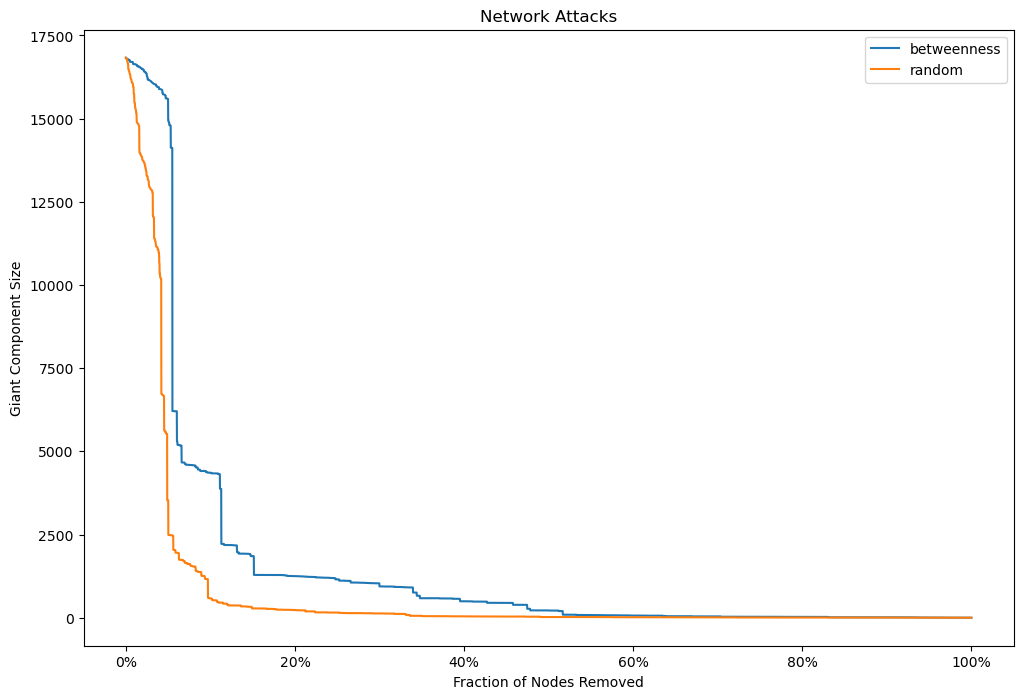

In [18]:
import operator
from random import shuffle
from random import randrange
from random import randint
import random
import matplotlib.ticker as mtick

sorted_x = sorted(between.items(), key=operator.itemgetter(1), reverse=True)
rand_x = list(range(0,16830))

random.shuffle(rand_x)
between_giant = []
between_rand = []
avg_degs = []

for x in range(16800):
 
        remove = sorted_x[x]      
        remove2 = sorted_x[rand_x[x]]
        S_simple.remove_nodes_from(remove)
        S_simple2.remove_nodes_from(remove2)
             
        giant = len(max((S_simple.subgraph(c) for c in nx.connected_components(S_simple)), key=len, default=0))
        giant2 = len(max((S_simple2.subgraph(c) for c in nx.connected_components(S_simple2)), key=len, default=0))

        between_giant.append(giant)
        between_rand.append(giant2)

y1 = between_giant
y2 = between_giant

y1= y1[ :-1]
y2= y2[1: ]

perc = np.linspace(0,100,len(between_giant))
fig = plt.figure(1, (12,8))
ax = fig.add_subplot(1,1,1)

ax.plot(perc, between_giant)
ax.plot(perc, between_rand)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
ax.set_xlabel('Fraction of Nodes Removed')
ax.set_ylabel('Giant Component Size')
ax.legend(['betweenness','random'])
ax.set_title('Network Attacks')
plt.show()

Recall that the node connectivity is 1, so it only takes 1 node to sever the connected network into multiple components. The Giant Component Size represents the number of nodes in the network whole as more and more nodes are taken away. The rapid decline in this size means that each individual node is important in maintaining the connectivity of the whole network. At around 18% of nodes deleted, we 1/5 of the size of the network and at 60% deletion, the routes are almost all disconnected. 

This may not be the best way to measure network robustness because taking away random nodes makes the network decline much faster than taking away what seems to be "important nodes" based on betweenness centrality. This may be because there may be redundancies for the nodes with high betweenness centrality, while any random node can detach a path/deadend.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed

# Create positive and negative examples for link prediction
edges = list(G.edges())
non_edges = list(nx.non_edges(G))
labels = [1] * len(edges) + [0] * len(non_edges)
pairs = edges + non_edges

# Compute embeddings for edge pairs
def get_edge_features(pair):
    return np.concatenate([node_embeddings[str(pair[0])], node_embeddings[str(pair[1])]])

# Use joblib to parallelize the feature extraction
n_jobs = -1  # Use all available cores
X = Parallel(n_jobs=n_jobs)(delayed(get_edge_features)(pair) for pair in pairs)
X = np.array(X)
y = np.array(labels)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc}")